# Evaluate accuracy of Foldseek TM-score calculation methods

This notebook explores how different foldseek settings impact alignment TM-score estimates.
Within TM-align mode of foldseek (`--alignment-type 1`), we explore two additional parameters below.

* `--tmalign-fast`: This parameter controls whether foldseek uses a faster version of TM-align mode. When set to 1, fast mode is turned on.
* `--exact-tmscore`: This parameter controls whether foldseek calculates exact TM-scores. When set to 1, exact scores are calculated.

Below, we use foldseek to query 3 human proteins (IL10, EIFS1, IL18BP) against all other human proteins.
We calculate use all four combinations of the above two parameters.
We then compare each result against the most accurate combination, `--alignment type 1 --tmalign-fast 0 --exact-tmscore 1`.
Previously, Evan has shown that this combination of arguments leads to almost exactly the same TM scores as TMalign (see [this PR comment](https://github.com/Arcadia-Science/2024-parasite-human-mimics/pull/17#issuecomment-2536987186))
(Note we also correct the alignment TM-scores when we read in the results, which are known to be inaccurate (see [this issue](https://github.com/steineggerlab/foldseek/issues/312))).

## TL;DR

`--tmalign-fast` needs to be turned off for accurate TM-score estimation.
Both `--alignment type 1 --tmalign-fast 0 --exact-tmscore 1` and `--alignment type 1 --tmalign-fast 0 --exact-tmscore 0` work approximately equally, though turning on `--exact-tmscore` leads to slight increases in accuracy.
Turning off `--tmalgin-fast` leads to a 4x slow down in run time when `--exact-tmscore` is off and a 5x slow down when `--exact-tmscore` is on.

## Documenting exact foldseek commands

The human structures are alphafold structures downloaded for canonical UniProt human proteomes.
We use the structures downloaded by the `viral.snakefile` in the root of this repository.
The 3 structures in `human_pos_controls` correspond to human IL10, EIFS1, and IL18BP.

We use foldseek as downloaded by conda.
Foldseek version:
`foldseek                  9.427df8a       pl5321h8ec77f5_1    bioconda`

We used these commands to run foldseek.
Only the two parameters discussed above and the output file names change between each command.
```bash
time foldseek easy-search human_pos_controls ../human/host_proteome_pdb_structures human-pos-controls-v-all-human-tmalignfast1-exacttmscore0.tsv tmp_foldseek --tmscore-threshold 0.0 --exhaustive-search 1 -e inf --tmalign-fast 1 --exact-tmscore 0  --alignment-type 1 --format-output query,target,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln --format-mode 4
```

took
```
1290.77s user 14.88s system 241% cpu 9:00.73 total
```

Added parameters `--tmalign-fast 0 --exact-tmscore 1`
```bash
time foldseek easy-search human_pos_controls ../human/host_proteome_pdb_structures human-pos-controls-v-all-human-tmalignfast0-exacttmscore1.tsv tmp_foldseek --tmscore-threshold 0.0 --exhaustive-search 1 -e inf --tmalign-fast 0 --exact-tmscore 1 --alignment-type 1 --format-output query,target,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln --format-mode 4
```
took 91 minutes
```
5463.48s user 16.12s system 191% cpu 47:40.14 total
```

```bash
time foldseek easy-search human_pos_controls ../human/host_proteome_pdb_structures human-pos-controls-v-all-human-tmalignfast1-exacttmscore1.tsv tmp_foldseek --tmscore-threshold 0.0 --exhaustive-search 1 -e inf --tmalign-fast 1 --exact-tmscore 1 --alignment-type 1 --format-output query,target,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln --format-mode 4
```

took
```
1817.28s user 11.73s system 170% cpu 17:50.89 total
```


```bash
time foldseek easy-search human_pos_controls ../human/host_proteome_pdb_structures human-pos-controls-v-all-human-tmalignfast0-exacttmscore0.tsv tmp_foldseek --tmscore-threshold 0.0 --exhaustive-search 1 -e inf --tmalign-fast 0 --exact-tmscore 0 --alignment-type 1 --format-output query,target,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln --format-mode 4
```

took
```
 4871.28s user 17.10s system 215% cpu 37:53.16 total
```


## Notebook setup

In [1]:
setwd("..")

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Compare the time it takes to run each mode

In [3]:
time_to_run  <- data.frame(mode = c("--tmalign-fast 1, --exact-tmscore 0", 
                                    "--tmalign-fast 0, --exact-tmscore 1",
                                    "--tmalign-fast 1, --exact-tmscore 1",
                                    "--tmalign-fast 0, --exact-tmscore 0"),
                           minutes = c(9, 47, 17, 38),
                           cpu_time = c(1290.77, 5463.8, 1817.28, 4871.28))

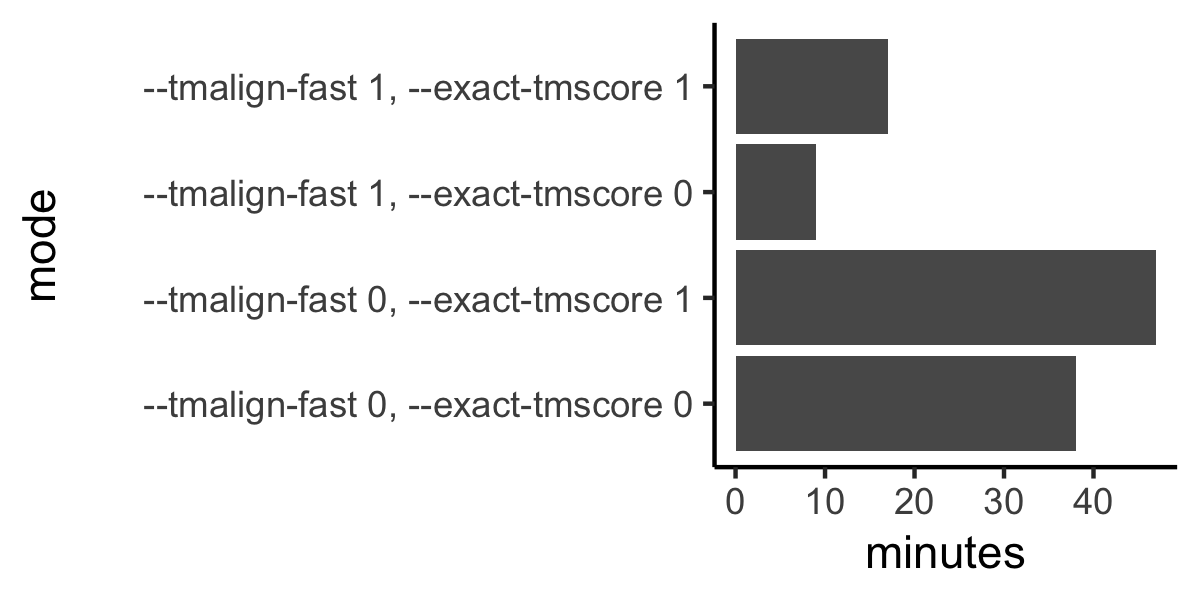

In [6]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 300)

ggplot(time_to_run, aes(x = mode, y = minutes)) +
  geom_col() +
  coord_flip() +
  theme_classic()

## Compare the results of each mode against `--tmalign-fast 0, --exact-tmscore 1`

In [7]:
# import the human gene metadata to keep recognizable gene names and descriptions in case they're useful
human_metadata <- read_csv("outputs/metadata/human_metadata_combined.csv", show_col_types = FALSE) %>%
  select(uniprot, uniprot_gene_names_primary, uniprot_function_cc) %>%
  distinct()

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


In [8]:
read_foldseek <- function(filepath, string) {
    df <- read_tsv(filepath, show_col_types = FALSE) %>%
      mutate(query = str_remove(string = query, pattern = ".pdb"),
             target = str_remove(string = target, pattern = ".pdb")) %>%
      left_join(human_metadata, by = c("query" = "uniprot")) %>%
      rename(query_name = uniprot_gene_names_primary, query_function = uniprot_function_cc) %>%
      left_join(human_metadata, by = c("target" = "uniprot")) %>%
      rename(target_name = uniprot_gene_names_primary, target_function = uniprot_function_cc) %>%
      select(query, query_name, target, target_name, target_function, qlen, tlen, alnlen, alntmscore, qtmscore, ttmscore, 
             lddt, qcov, tcov, pident, bits, evalue, qstart, qend, tstart, tend) %>%
      mutate(tmraw1 = qtmscore * qlen,
             tmraw2 = ttmscore * tlen,
             tmraw = (tmraw1 + tmraw2) / 2,
             alntmscore = tmraw/alnlen) %>%
      select(-tmraw1, -tmraw2, -tmraw) %>%
      rename_with(~ paste0(., string), .cols = c(alnlen, alntmscore, qtmscore, ttmscore, 
                                                 lddt, qcov, tcov, pident, bits, evalue, 
                                                 qstart, qend, tstart, tend))
}

In [9]:
tmalignfast1_exacttmscore0 <- read_foldseek(filepath = "outputs/viral/positive_control_tests/human-pos-controls-v-all-human-tmalignfast1-exacttmscore0.tsv",
                                            string = "_tmalignfast1_exacttmscore0")                 

In [10]:
tmalignfast0_exacttmscore1 <- read_foldseek("outputs/viral/positive_control_tests/human-pos-controls-v-all-human-tmalignfast0-exacttmscore1.tsv",
                                            string = "_tmalignfast0_exacttmscore1")

In [11]:
tmalignfast1_exacttmscore1 <- read_foldseek("outputs/viral/positive_control_tests/human-pos-controls-v-all-human-tmalignfast1-exacttmscore1.tsv",
                                            string = "_tmalignfast1_exacttmscore1")

In [12]:
tmalignfast0_exacttmscore0 <- read_foldseek("outputs/viral/positive_control_tests/human-pos-controls-v-all-human-tmalignfast0-exacttmscore0.tsv",
                                            string = "_tmalignfast0_exacttmscore0")

In [13]:
# join everything together into one data frame that can be compared

all <- left_join(tmalignfast0_exacttmscore1, tmalignfast1_exacttmscore0) %>%
  left_join(tmalignfast1_exacttmscore1) %>%
  left_join(tmalignfast0_exacttmscore0)

nrow(all)/3

Joining with `by = join_by(query, query_name, target, target_name, target_function, qlen, tlen)`
Joining with `by = join_by(query, query_name, target, target_name, target_function, qlen, tlen)`
Joining with `by = join_by(query, query_name, target, target_name, target_function, qlen, tlen)`


[1] 20198

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`).”


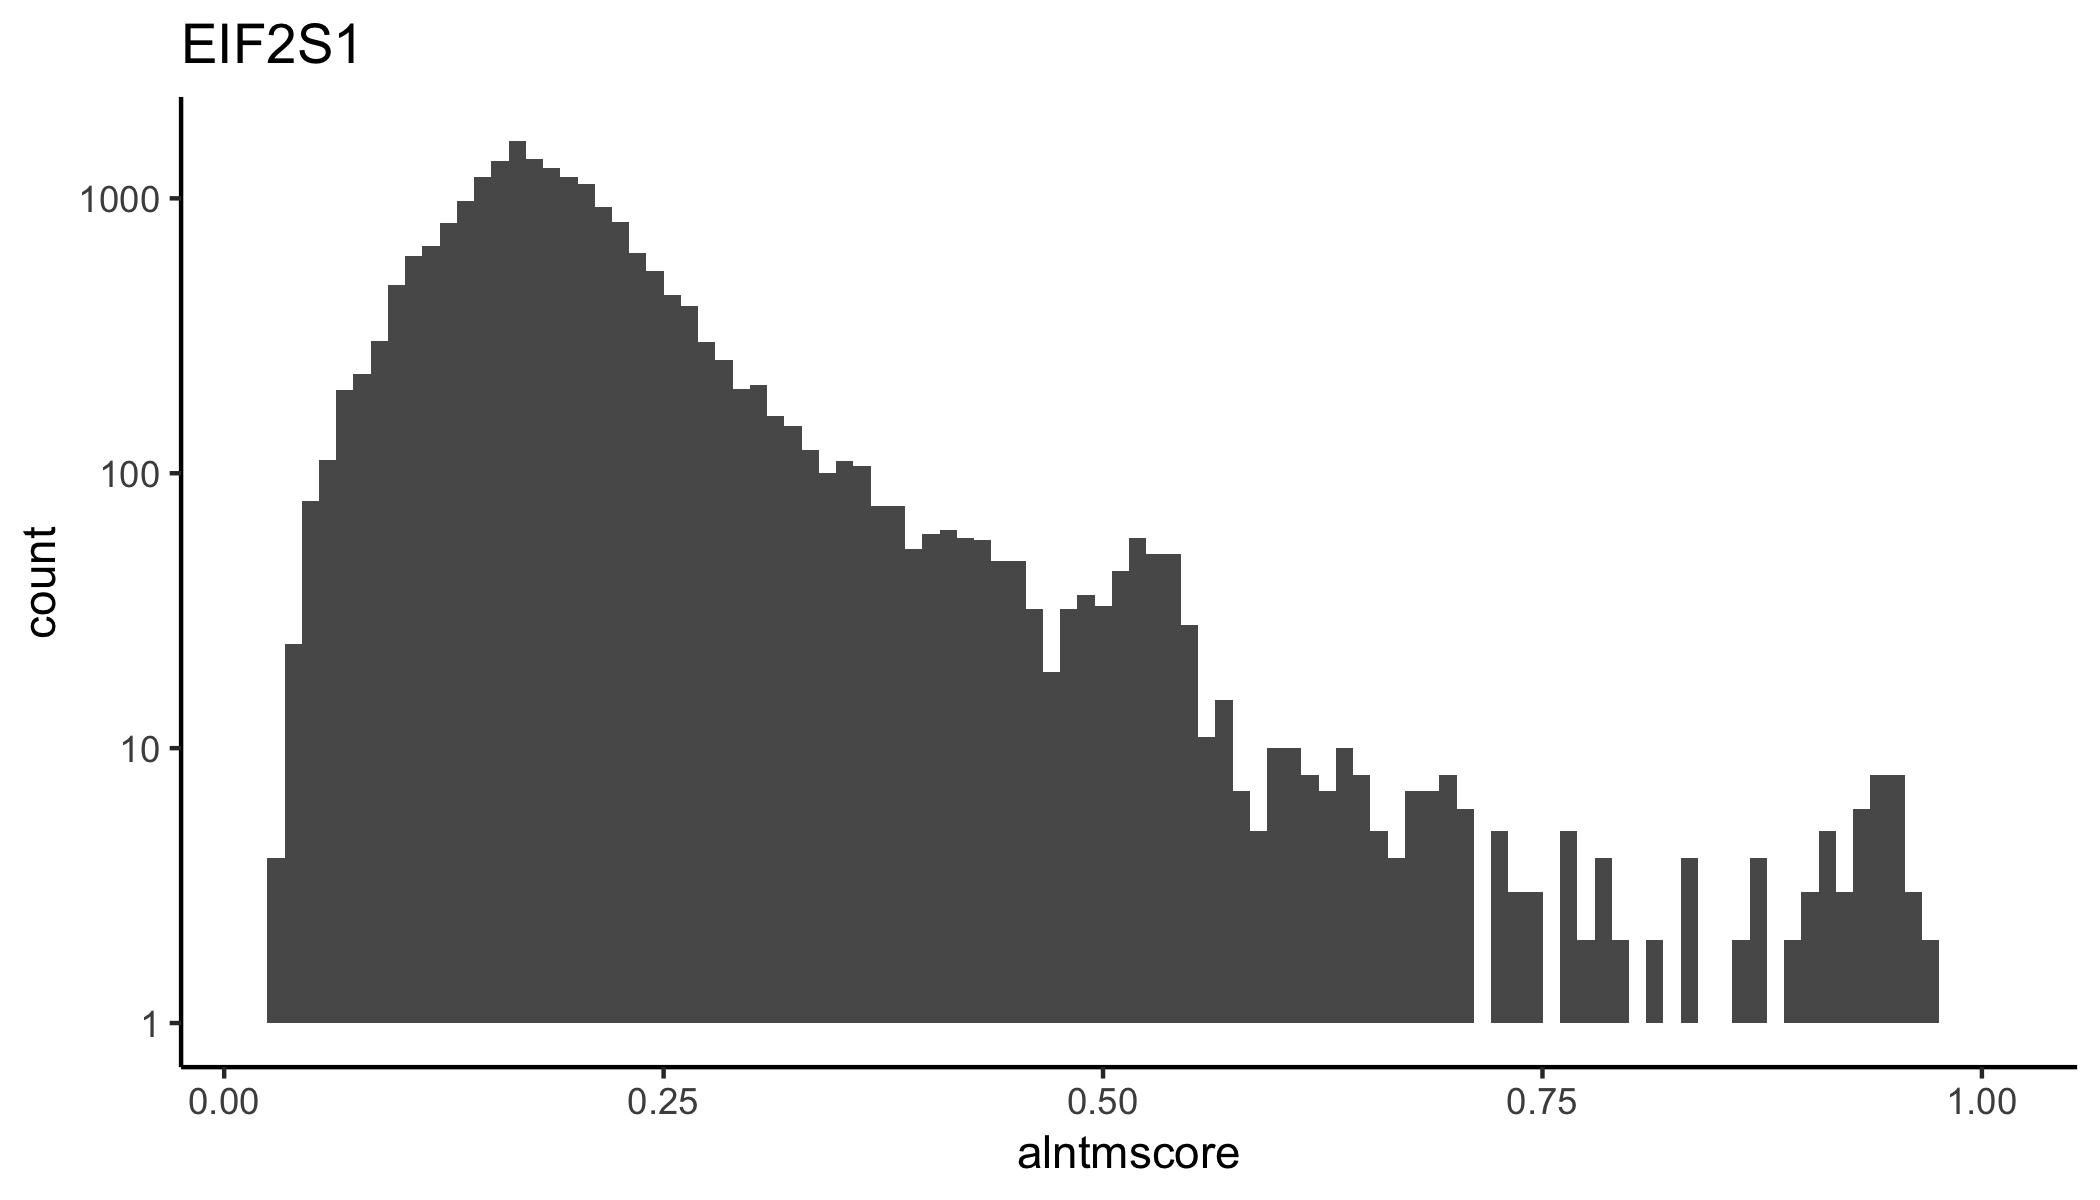

In [132]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

ggplot(eif2s1, aes(x = alntmscore)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  labs(title = "EIF2S1") 

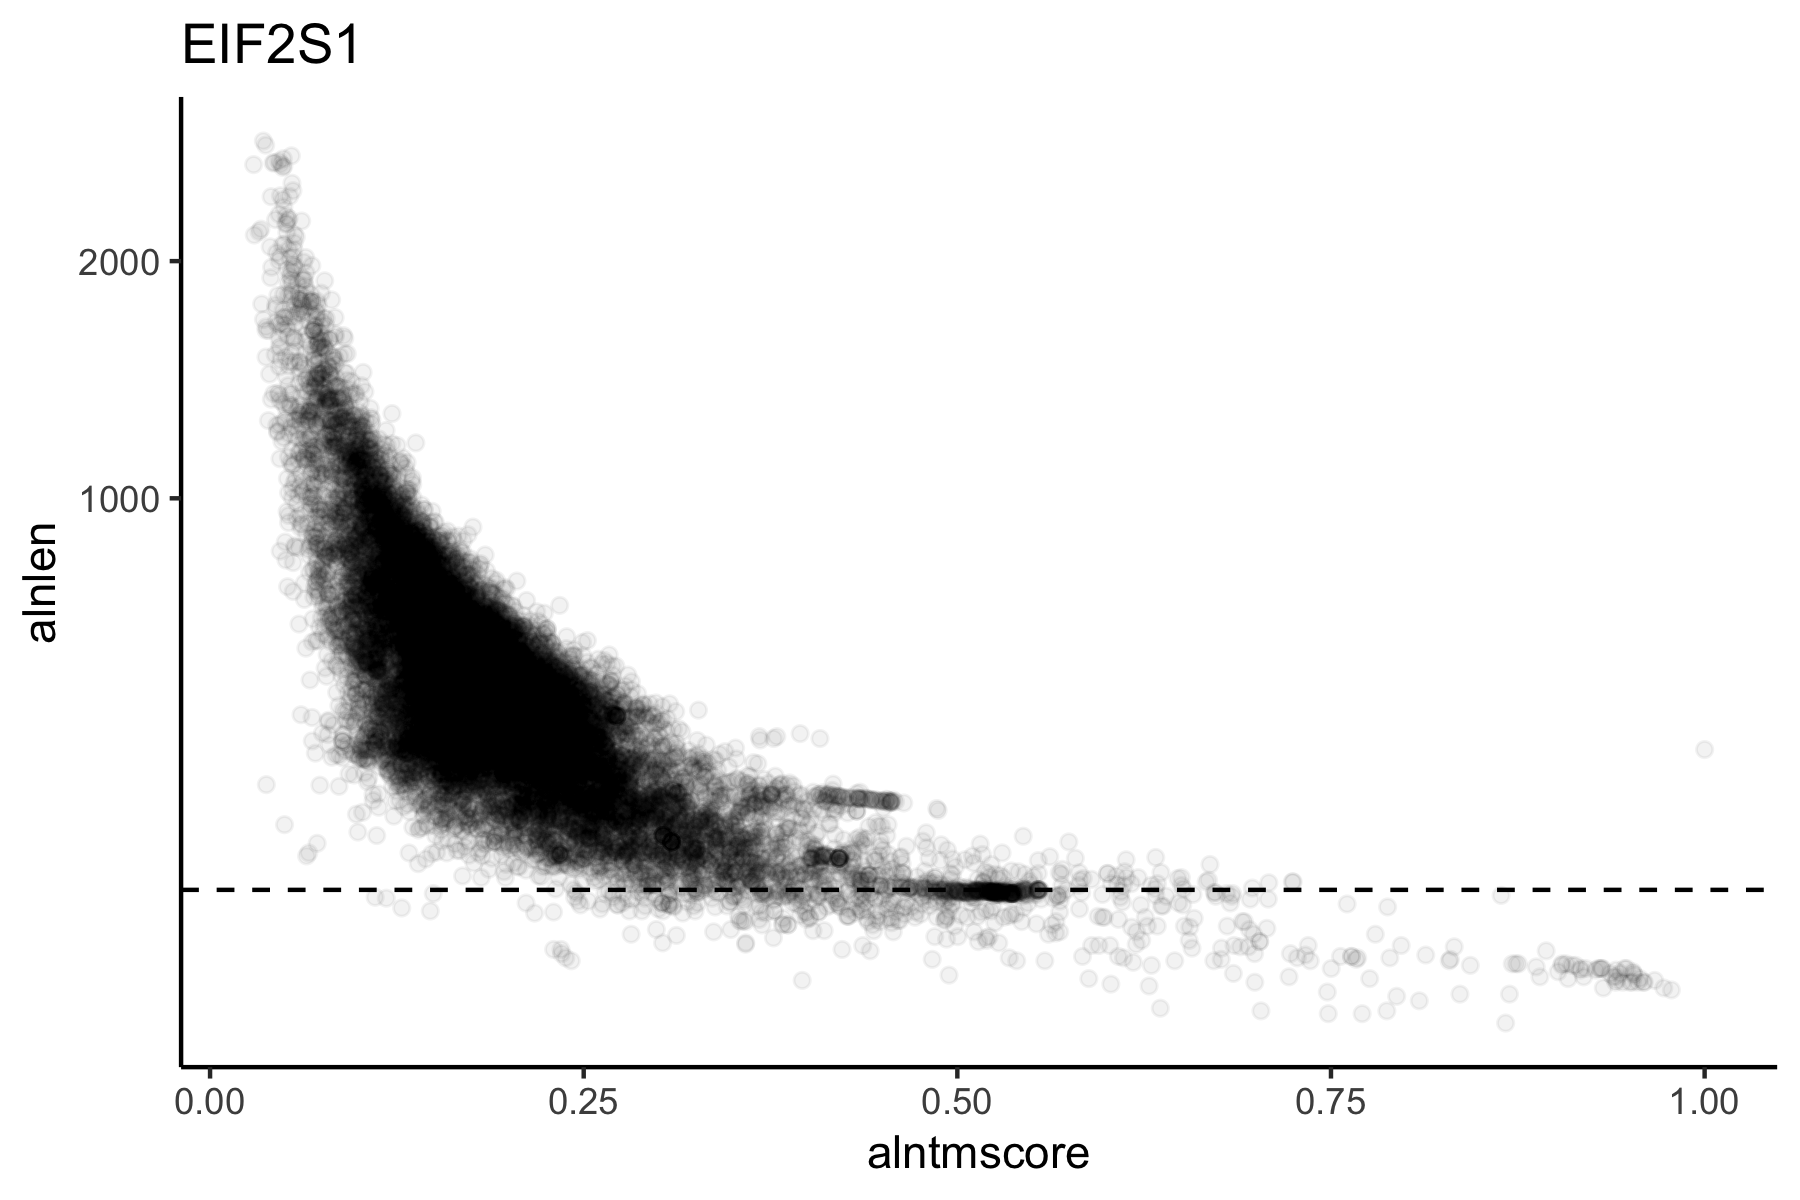

In [149]:
ggplot(eif2s1, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .05) +
  geom_hline(yintercept = 100, linetype = "dashed") +
  theme_classic() +
  labs(title = "EIF2S1") +
  #geom_label_repel(data = subset(eif2s1, alntmscore > 0.87), aes(y = tlen, label = target_name),
  #                 max.overlaps = 100, size = 2) +
  scale_y_sqrt()

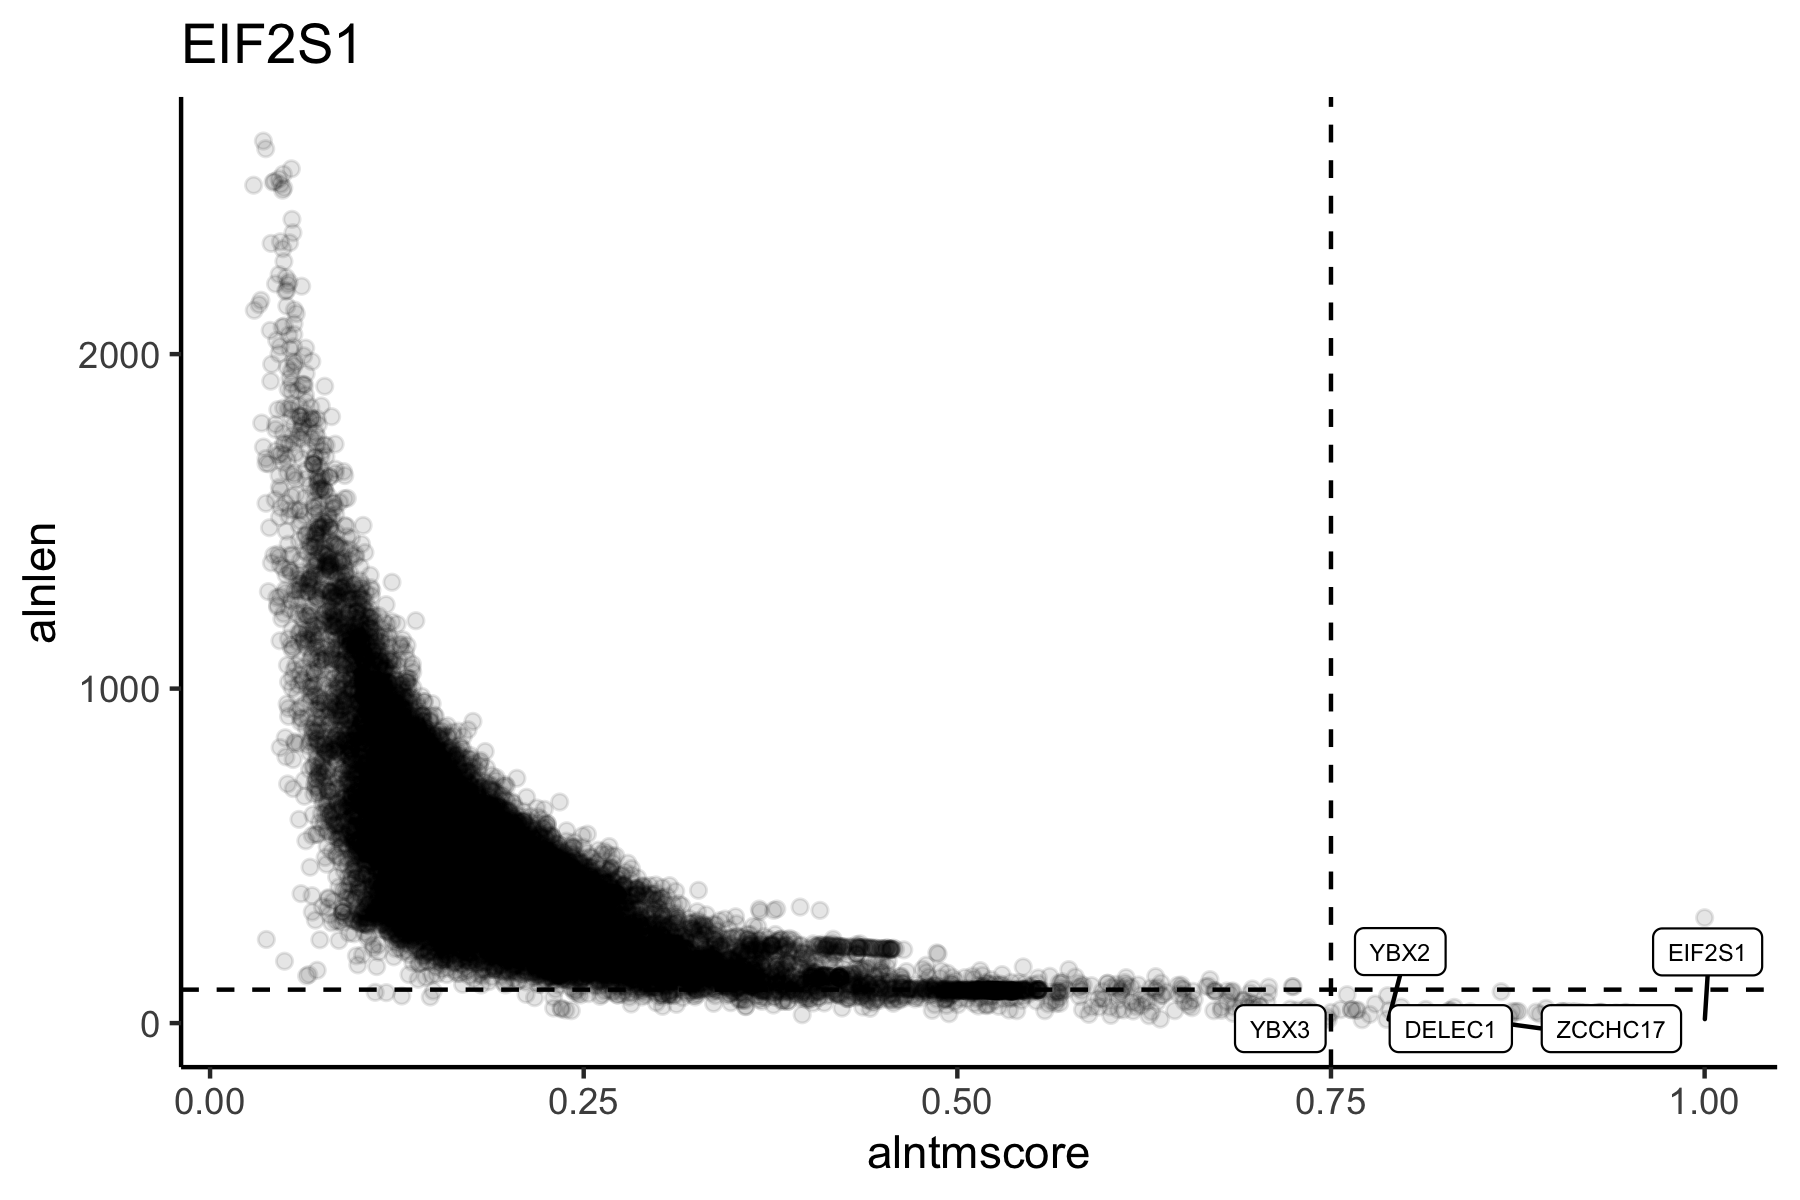

In [150]:
ggplot(eif2s1, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .1) +
  geom_hline(yintercept = 100, linetype = "dashed") +
  geom_vline(xintercept = 0.75, linetype = "dashed") +
  theme_classic() +
  labs(title = "EIF2S1") +
  geom_label_repel(data = subset(eif2s1 %>% filter(qcov > 0.15), alntmscore > 0.75), aes(y = qcov, label = target_name),
                   max.overlaps = 100, size = 2)

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_bar()`).”


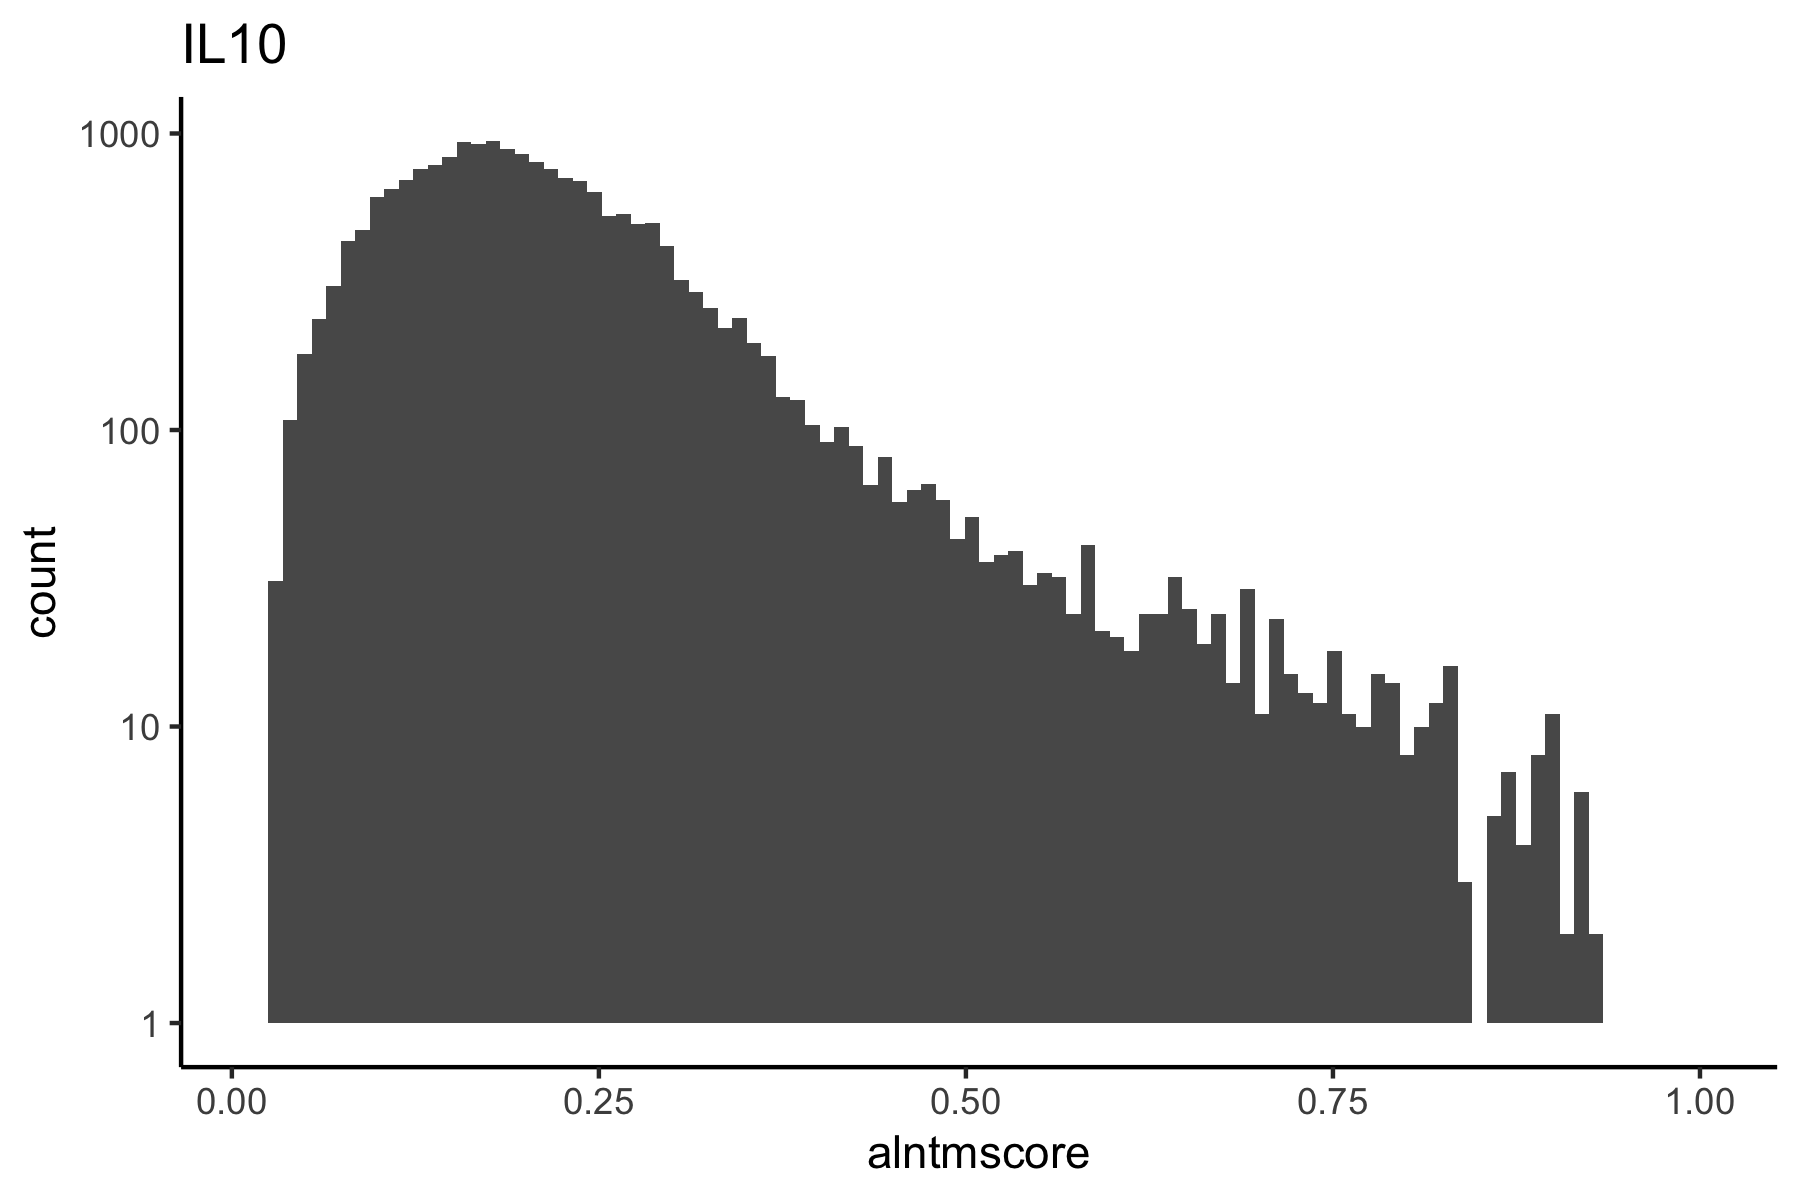

In [151]:
ggplot(il10, aes(x = alntmscore)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  labs(title = "IL10")

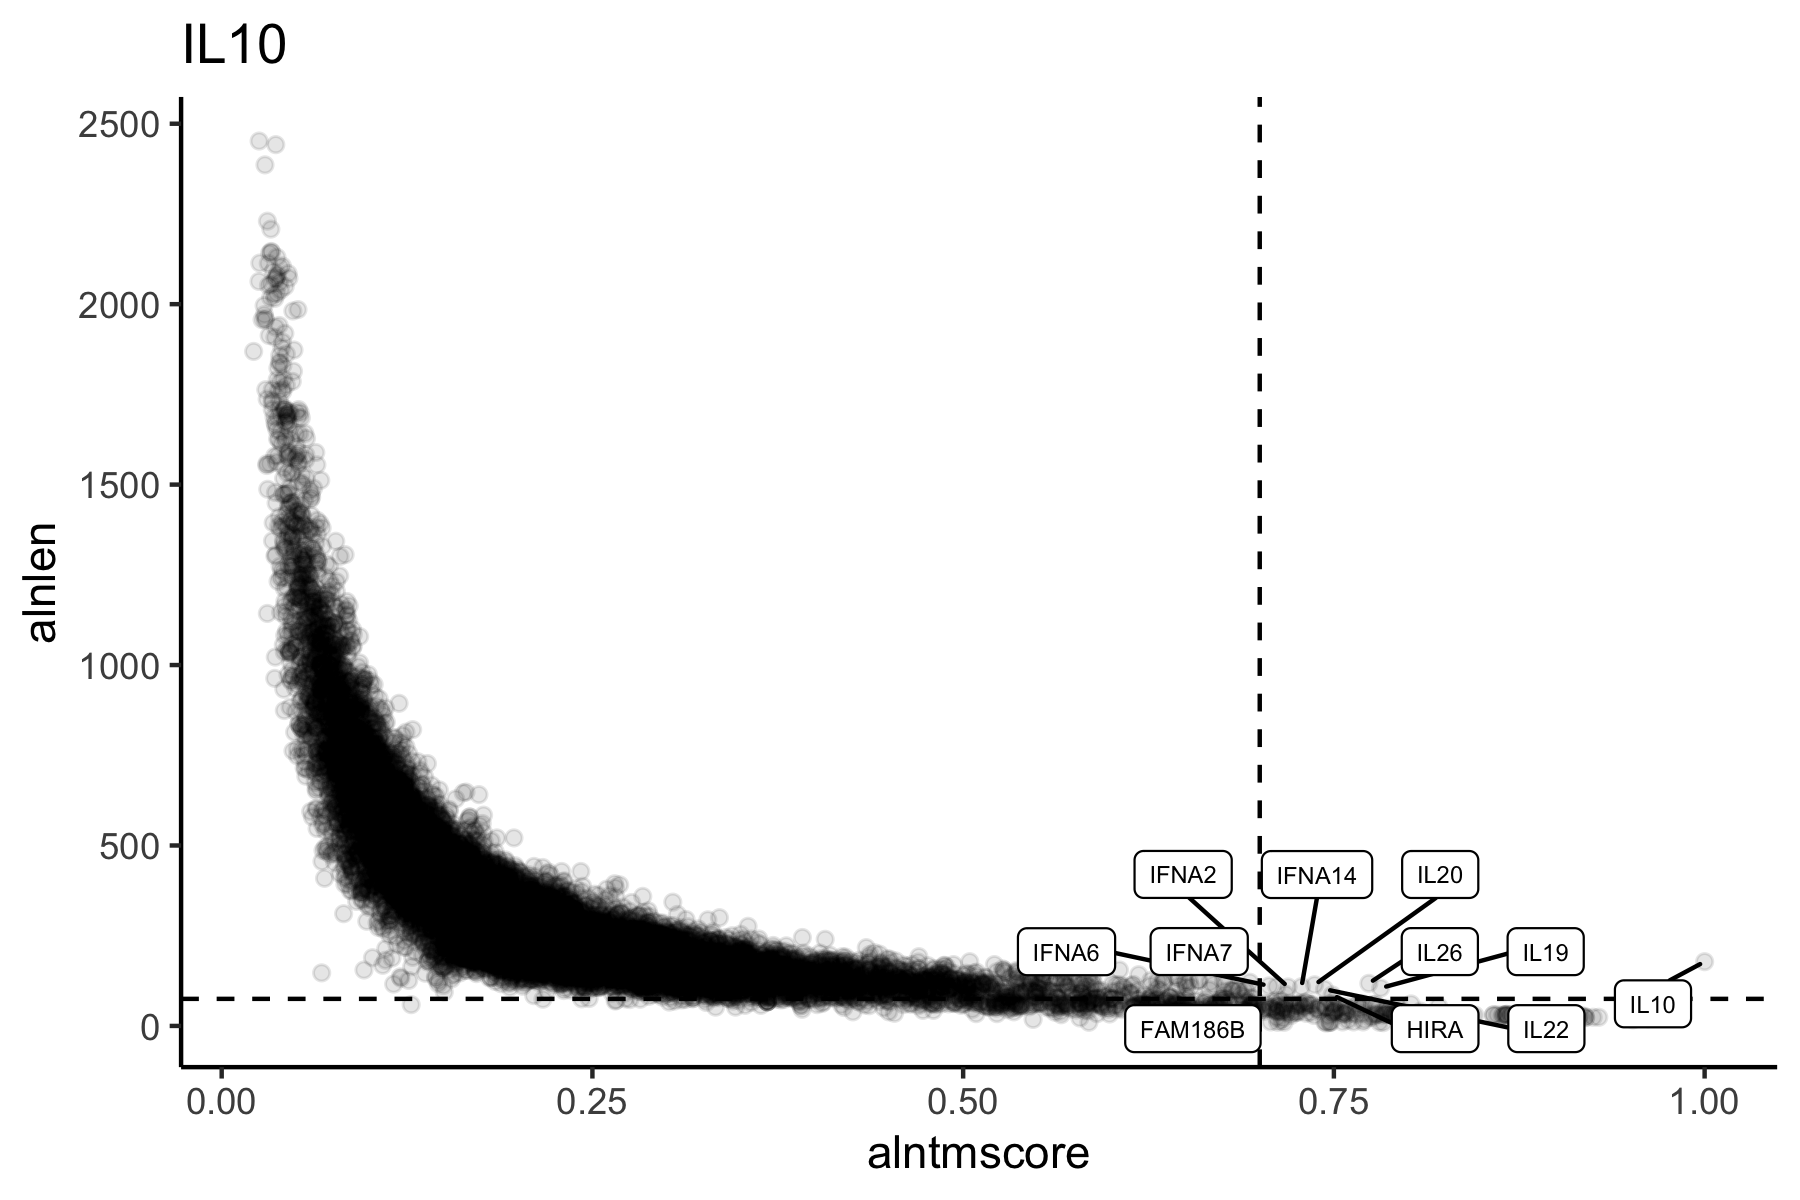

In [157]:
ggplot(il10, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .1) +
  geom_hline(yintercept = 75, linetype = "dashed") +
  geom_vline(xintercept = 0.7, linetype = "dashed") +
  theme_classic() +
  labs(title = "IL10") +
  geom_label_repel(data = subset(il10 %>% filter(alnlen > 75), alntmscore > 0.7), aes(y = alnlen, label = target_name),
                   max.overlaps = 100, size = 2)

Warning message:
“ggrepel: 34 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


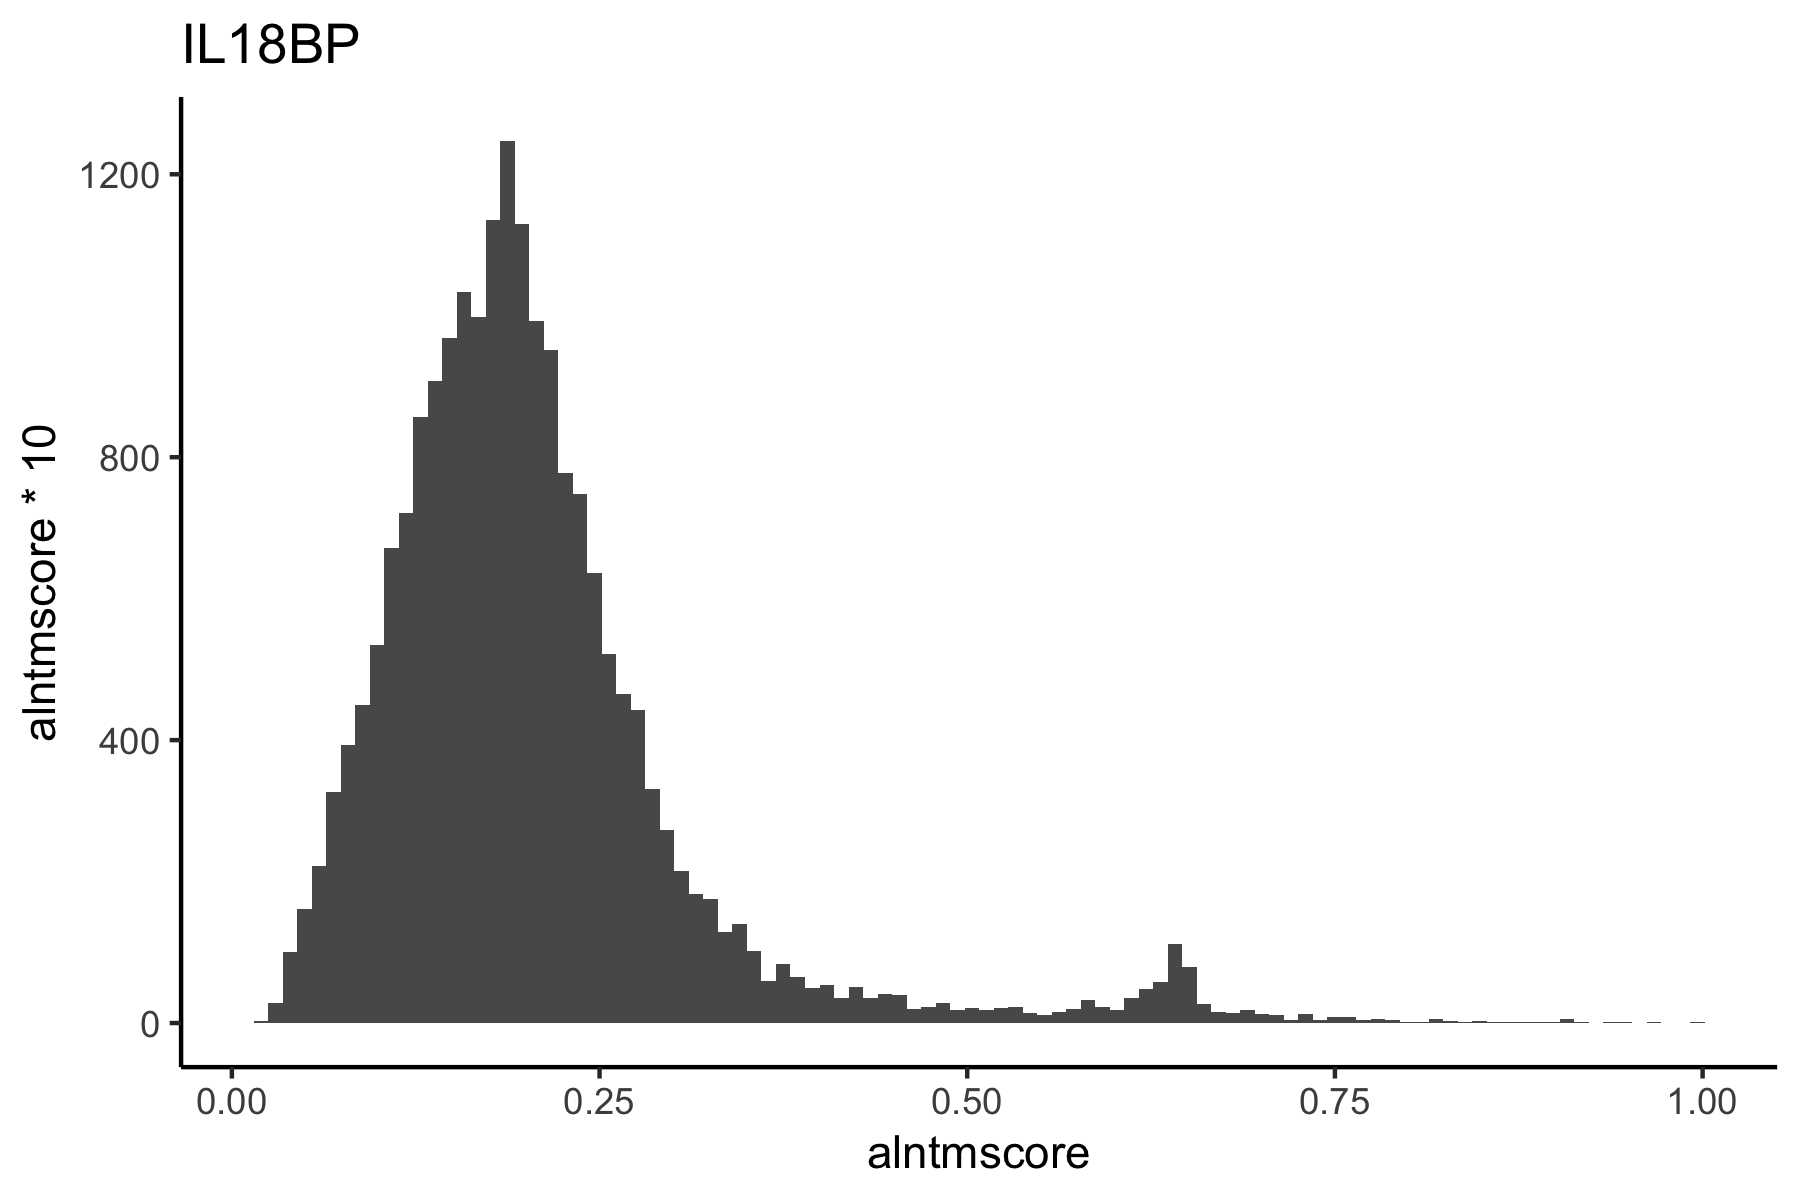

In [158]:
ggplot(il18bp, aes(x = alntmscore)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  labs(title = "IL18BP") +
  geom_text_repel(data = subset(il18bp, alntmscore > 0.8), aes(y = alntmscore * 10, label = target),
                 max.overlaps = 10) 

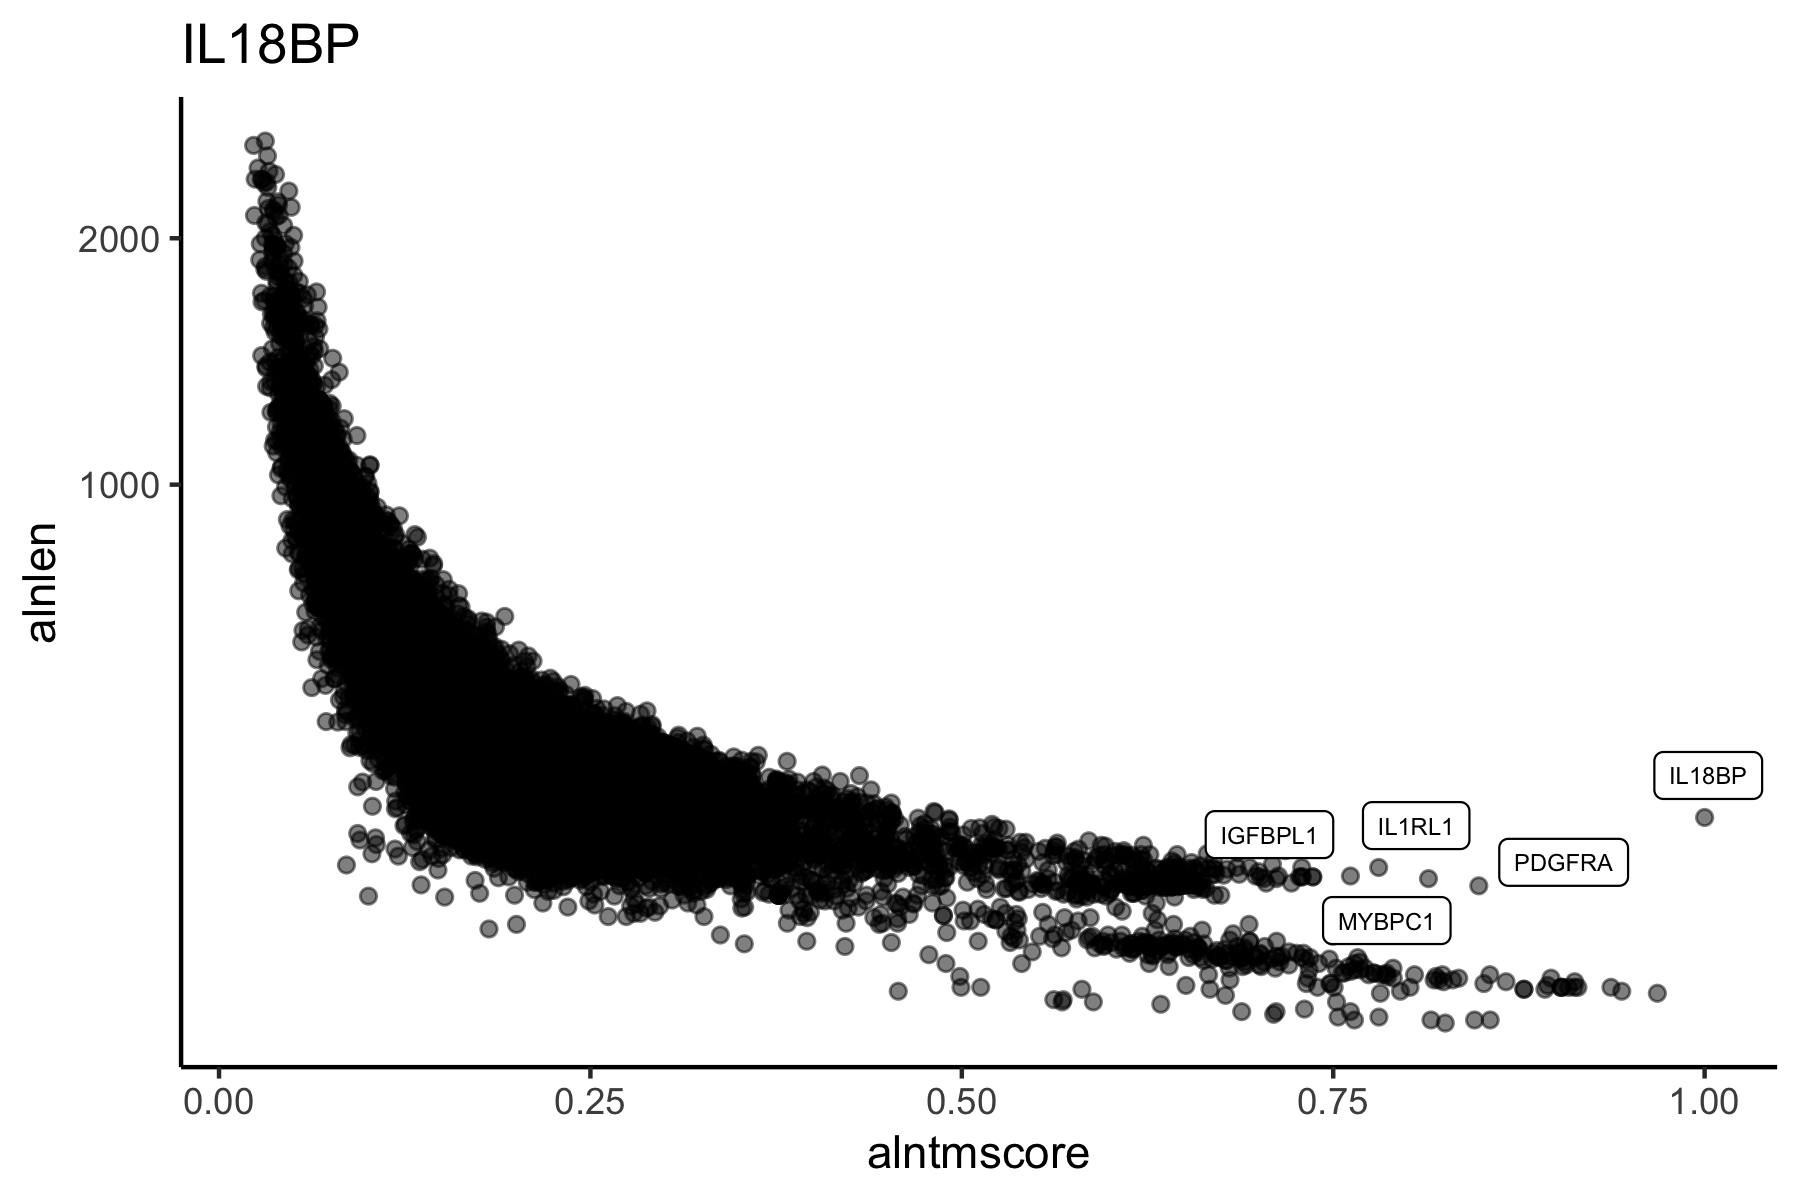

In [163]:
ggplot(il18bp, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .5) +
  theme_classic() +
  labs(title = "IL18BP") +
  geom_label_repel(data = subset(il18bp %>% filter(alnlen > 75), alntmscore > 0.75), aes(y = alnlen, label = target_name),
                   max.overlaps = 100, size = 2) +
  scale_y_sqrt()

## Compare first set of results to exact results: IL10

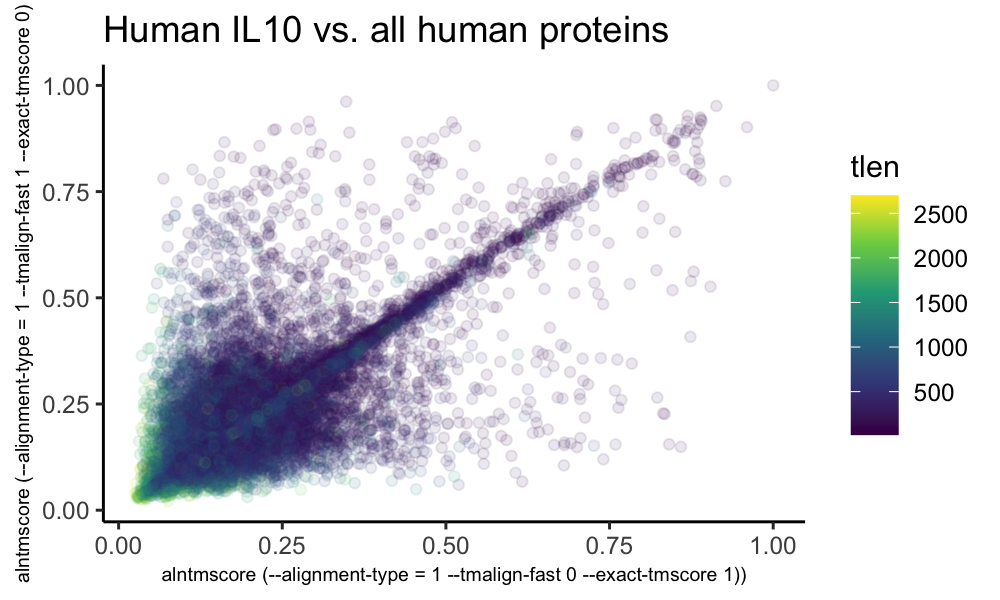

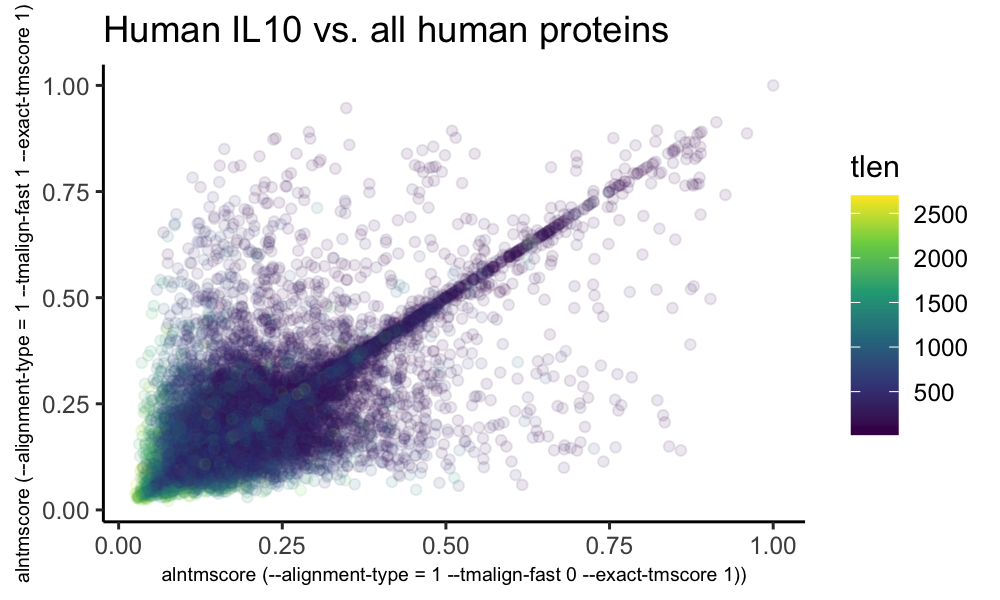

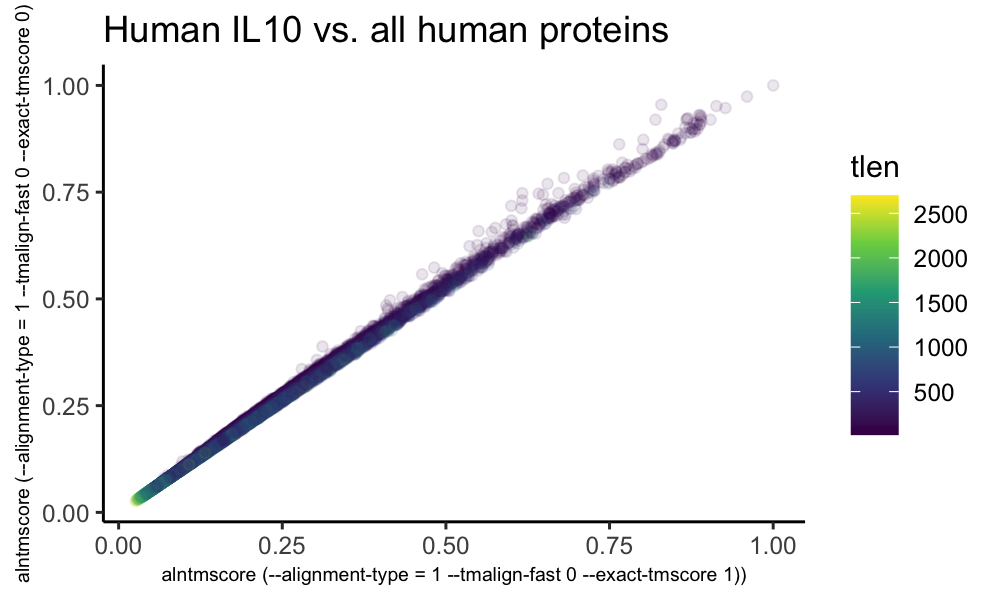

In [14]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

vs_tmalignfast1_exacttmscore0 <- ggplot(all %>% filter(query_name == "IL10"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast1_exacttmscore0,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human IL10 vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 1 --exact-tmscore 0)") +
  theme(axis.title = element_text(size = 7))


vs_tmalignfast1_exacttmscore1 <- ggplot(all %>% filter(query_name == "IL10"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast1_exacttmscore1,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human IL10 vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 1 --exact-tmscore 1)") +
  theme(axis.title = element_text(size = 7))

vs_tmalignfast0_exacttmscore0 <- ggplot(all %>% filter(query_name == "IL10"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast0_exacttmscore0,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human IL10 vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 0)") +
  theme(axis.title = element_text(size = 7))

vs_tmalignfast1_exacttmscore0
vs_tmalignfast1_exacttmscore1
vs_tmalignfast0_exacttmscore0

## Compare first set of results to exact results: EIF2A (S1)

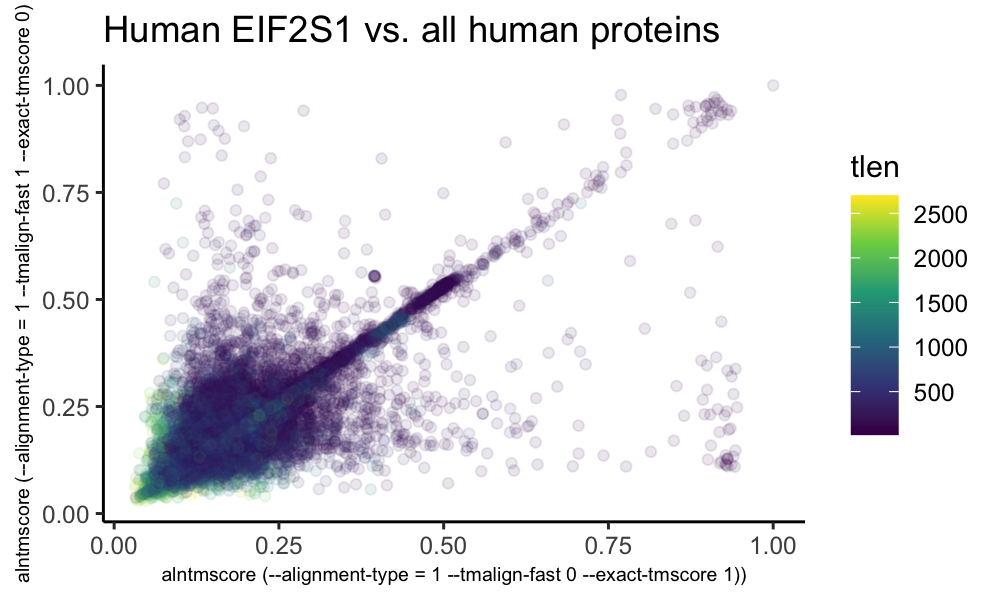

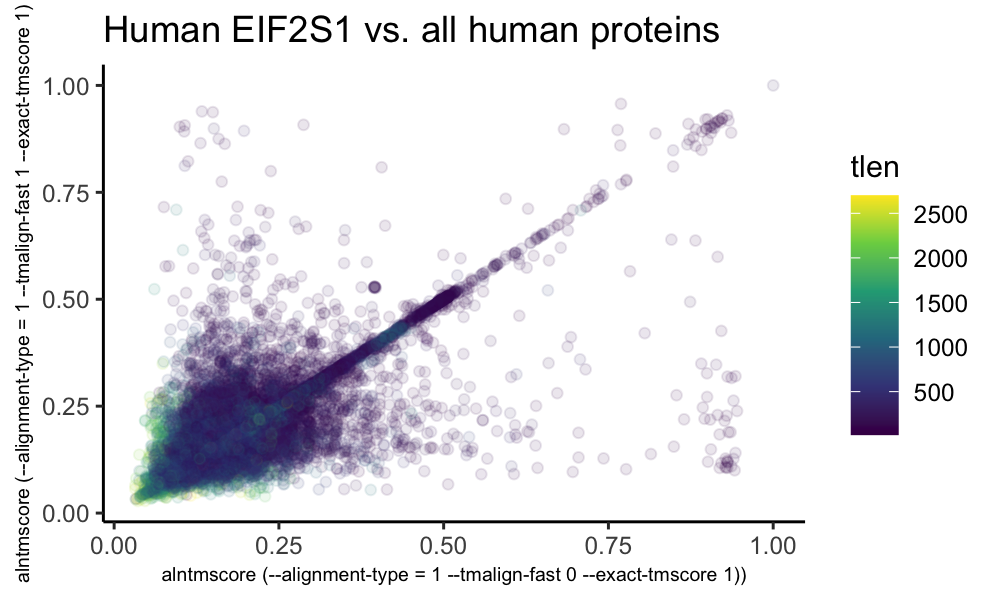

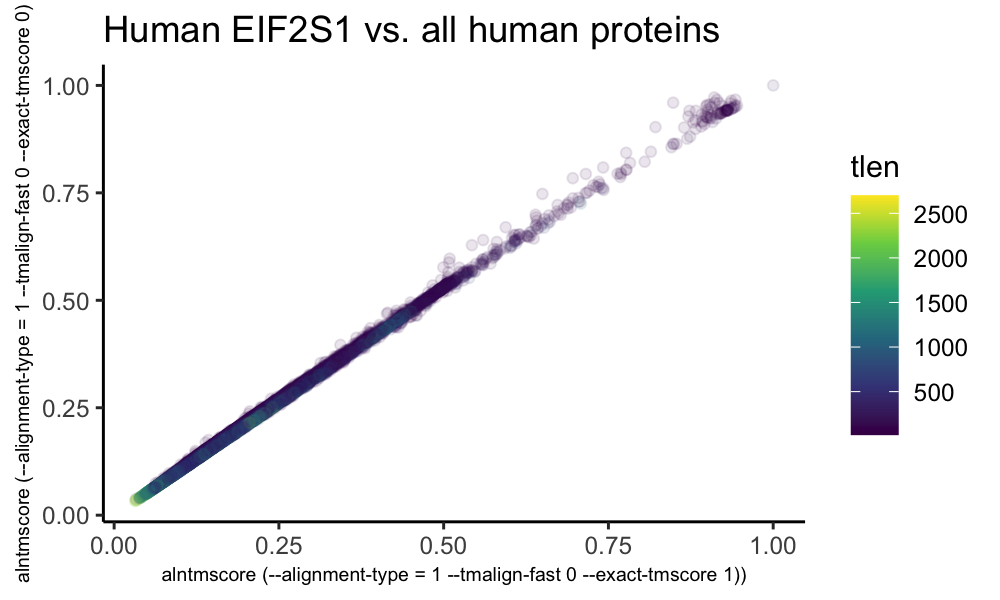

In [15]:
vs_tmalignfast1_exacttmscore0 <- ggplot(all %>% filter(query_name == "EIF2S1"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast1_exacttmscore0,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human EIF2S1 vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 1 --exact-tmscore 0)") +
  theme(axis.title = element_text(size = 7))


vs_tmalignfast1_exacttmscore1 <- ggplot(all %>% filter(query_name == "EIF2S1"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast1_exacttmscore1,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human EIF2S1 vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 1 --exact-tmscore 1)") +
  theme(axis.title = element_text(size = 7))

vs_tmalignfast0_exacttmscore0 <- ggplot(all %>% filter(query_name == "EIF2S1"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast0_exacttmscore0,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human EIF2S1 vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 0)") +
  theme(axis.title = element_text(size = 7))

vs_tmalignfast1_exacttmscore0
vs_tmalignfast1_exacttmscore1
vs_tmalignfast0_exacttmscore0

## Compare first set of results to exact results: IL18BP

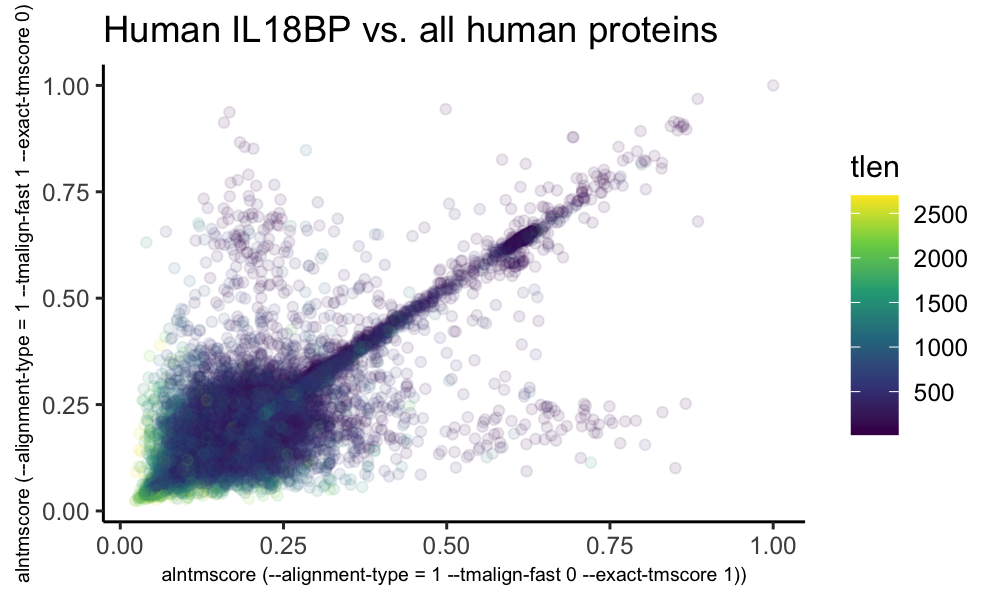

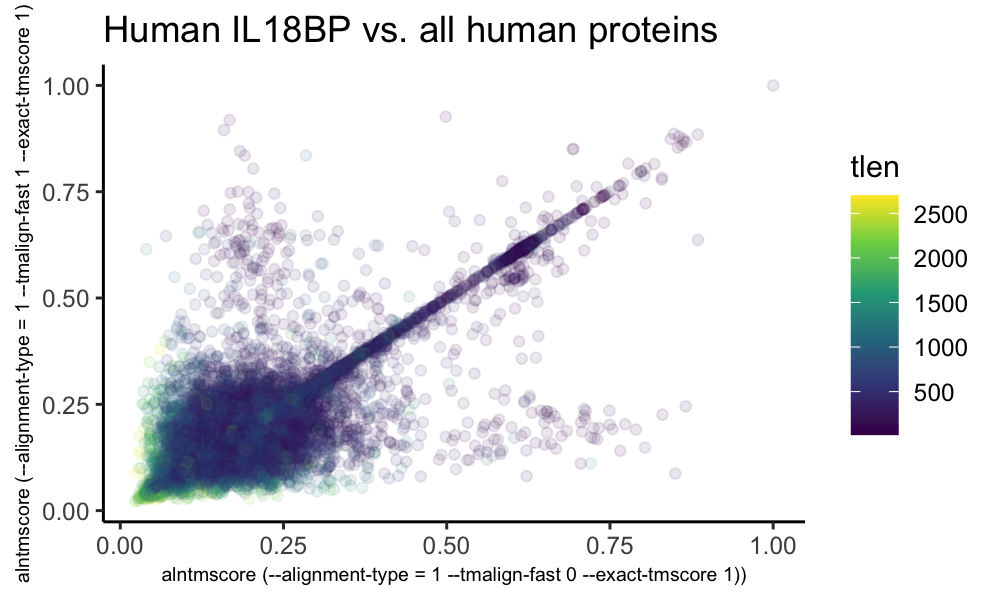

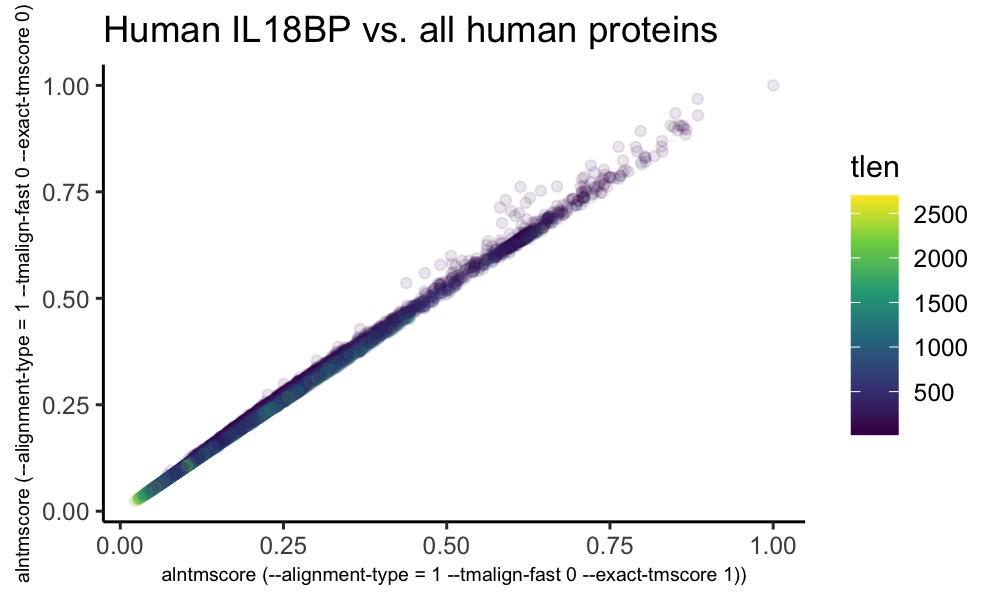

In [16]:
vs_tmalignfast1_exacttmscore0 <- ggplot(all %>% filter(query_name == "IL18BP"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast1_exacttmscore0,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human IL18BP vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 1 --exact-tmscore 0)") +
  theme(axis.title = element_text(size = 7))


vs_tmalignfast1_exacttmscore1 <- ggplot(all %>% filter(query_name == "IL18BP"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast1_exacttmscore1,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human IL18BP vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 1 --exact-tmscore 1)") +
  theme(axis.title = element_text(size = 7))

vs_tmalignfast0_exacttmscore0 <- ggplot(all %>% filter(query_name == "IL18BP"), aes(x = alntmscore_tmalignfast0_exacttmscore1, 
                                                 y = alntmscore_tmalignfast0_exacttmscore0,
                                                 color = tlen)) +
  geom_point(alpha = 1/10) +
  theme_classic() +
  scale_color_viridis_c() +
  labs(title = "Human IL18BP vs. all human proteins", 
       x = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 1))",
       y = "alntmscore (--alignment-type = 1 --tmalign-fast 0 --exact-tmscore 0)") +
  theme(axis.title = element_text(size = 7))

vs_tmalignfast1_exacttmscore0
vs_tmalignfast1_exacttmscore1
vs_tmalignfast0_exacttmscore0

In [17]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [5] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
 [9] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] bit_4.0.5         gtable_0.3.5      jsonlite_1.8.8    compiler_4.3.3   
 [5] crayon_1.5.2      tidyselect_1.2.0  IRdisplay_1.1     parallel_4.3.3   
 [9] scales_1.3.0      uuid_1.2-0        fastmap_1.1.1     IRkernel_1.3.2   
[13] R6_2.5.1          labeling_0.4.3    g